In [1]:
import numpy as np
from scipy.integrate import quad as sc_quad
from scipy.special import gamma as sc_gamma
import matplotlib.pyplot as plt

In [2]:
filename = "scenario_1.npz"

In [3]:
data = np.load(filename)
S = data["S"]
I = data["I"]
R = data["R"]

S_0 = S[0]
I_0 = I[0]
R_0 = R[0]
N_0 = S_0 + I_0 + R_0
Delta_I = np.concatenate([[I_0], S[:-1] - S[1:]])
Delta_R = np.concatenate([[R_0], R[1:] - R[:-1]])
P = I / N_0
T = len(S)
p = 0.01

print(S_0, I_0, R_0, N_0, T)

999950.0 50.0 0.0 1000000.0 100


In [4]:
# define the prior distributions


def prior_delta(T, p):
    # the first element has to be 1
    return np.concatenate([[1], np.random.binomial(1, p, size=T - 1)])


def prior_r(K: int):
    return np.random.gamma(shape=0.1, scale=0.1, size=K)


def prior_b(K):
    return np.random.gamma(shape=0.1, scale=0.1, size=K)


def prior_gamma(delta, r):
    eta = np.cumsum(delta)
    gamma = np.random.beta(a=r[eta - 1], b=1)
    return gamma


def prior_beta(delta, b):
    eta = np.cumsum(delta)
    beta = np.random.exponential(scale=b[eta - 1])
    return beta

In [5]:
# define the sampling parameters
n_samplings = 1000_000

delta = np.zeros((n_samplings, T))
r = np.zeros((n_samplings, T+1))
b = np.zeros((n_samplings, T+1))
beta = np.zeros((n_samplings, T))
gamma = np.zeros((n_samplings, T))
K = np.zeros(n_samplings, dtype=int)
eta = np.zeros((n_samplings, T))

In [6]:
def init(T, p):
    delta_tmp = prior_delta(T, p)
    K_0 = np.sum(delta_tmp)
    r_temp = prior_r(K_0)
    b_temp = prior_b(K_0)

    delta[0, :] = delta_tmp
    r[0, 0:K_0] = r_temp
    b[0, 0:K_0] = b_temp
    gamma[0, :] = prior_gamma(delta_tmp, r_temp)
    beta[0, :] = prior_beta(delta_tmp, b_temp)
    eta[0, :] = np.cumsum(delta_tmp)
    K[0] = K_0

In [7]:
def mylog(x):
    try:
        x = np.array(x)
        mask = x > 1e-323
        output = np.zeros(len(x))
        output[mask] = np.log(x[mask])
        output[~mask] = -744
        return output
    except:
        return np.log(x) if x > 0 else -744

In [8]:
init(T, p)

In [9]:
def add(delta_):
    index_tmp = np.where(delta_ == 0)[0]
    np.random.shuffle(index_tmp)
    zero_index = index_tmp[0]
    delta_[zero_index] = 1
    return delta_


def delete(delta_):
    index_tmp = np.where(delta_ == 1)[0]
    np.random.shuffle(index_tmp)
    zero_index = index_tmp[0]
    delta_[zero_index] = 0
    return delta_


def swap(delta_):
    tmp = delta_[1:] + delta_[:-1]

    index_tmp = np.where(tmp == 1)[0] + 1
    np.random.shuffle(index_tmp)
    shuffling_index = index_tmp[0]

    tmp_value = delta_[shuffling_index - 1]
    delta_[shuffling_index - 1] = delta_[shuffling_index]
    delta_[shuffling_index] = tmp_value

    return delta_

In [10]:
def likelihood(beta, gamma, delta, K):
    eta = np.cumsum(delta)
    sum_1 = 0
    for k in range(1, int(K)):
        mask_ = eta == k
        n = np.sum(mask_)
        sum_beta = np.sum(beta[mask_])
        sum_gamma = np.sum(mylog(gamma[mask_]))
        sum_1 += 0.2 * mylog(0.1) - 2 * mylog(sc_gamma(0.1))
        sum_1 += 2 * mylog(sc_gamma(0.1 + n))
        sum_1 -= (0.1 + n) * mylog((0.1 + sum_beta) * (0.1 - sum_gamma))
    return sum_1

In [11]:
def J_ratio(K_g, K_, T):
    k_k = (K_, K_g)
    if K_ == K_g:
        return 1
    elif k_k == (1, 2) or k_k == (T, T - 1):
        return 3 / (T - 1)
    elif k_k == (2, 1) or k_k == (T - 1, T):
        return (T - 1) / 3
    elif K_g == K_ + 1:
        return (K_g - 1) / (T - K_)
    elif K_g == K_ - 1:
        return (T - K_) / (K_g - 1)
    else:
        raise Exception("J_ratio is wrong")

In [12]:
for n in range(1, n_samplings):
    # load for convenience
    beta_g = beta[n - 1, :]
    gamma_g = gamma[n - 1, :]
    delta_g = delta[n - 1, :]
    K_g = K[n - 1]

    # propose the move for delta
    delta_ = delta_g[:]
    if K_g == 1:  # add
        delta_ = add(delta_)
    elif K_g == T:  # delete
        delta_ = delete(delta_)
    else:  # random
        case = np.random.random()
        if case < 1 / 3:
            delta_ = add(delta_)
        elif case < 2 / 3:
            delta_ = delete(delta_)
        else:
            delta_ = swap(delta_)
    K_ = np.sum(delta_)

    # metropolis hastings for delta
    mh = (
        mylog((p / (1 - p)) ** (K_ - K_g))
        + likelihood(beta_g, gamma_g, delta_, K_)
        - likelihood(beta_g, gamma_g, delta_, K_g)
        + mylog(J_ratio(K_g, K_, T))
    )

    temp_1 = np.log(np.random.random())
    if mh > temp_1:
        delta[n, :] = delta_
        delta_g = delta_

    else:
        delta[n, :] = delta_g

    # updated K and eta
    K[n] = int(np.sum(delta[n, :]))
    eta[n, :] = np.cumsum(delta[n, :], dtype=int)

    # update b and r
    for k in range(K[n]):
        shape_b = 0.1 + np.sum(eta[n, :] == k)
        scale_b = 0.1 + np.sum(beta_g[eta[n, :] == k])

        shape_r = shape_b
        scale_r = 0.1 + np.sum(-mylog(gamma_g[eta[n, :] == k]))

        b[n, k] = np.random.gamma(shape=shape_b, scale=scale_b, size=1)
        r[n, k] = np.random.gamma(shape=shape_r, scale=scale_r, size=1)

    for t in range(1, T):
        y = np.random.beta(
            a=(S[t - 1] - Delta_I[t]) + b[n, int(eta[n, t])] + 1, b=Delta_I[t] + 1
        )
        beta[n, t] = -mylog(y) / P[t - 1]
        gamma[n, t] = np.random.beta(
            a=Delta_R[t] + r[n, int(eta[n, t])], b=1 + I[t - 1] - Delta_R[t]
        )

Text(0, 0.5, 'Beta')

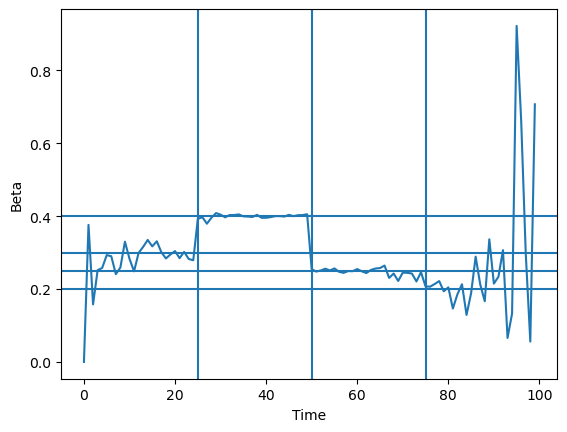

In [ ]:
plt.plot(beta[-1, :])
plt.axvline(25)
plt.axvline(50)
plt.axvline(75)
plt.axhline(0.3)
plt.axhline(0.4)
plt.axhline(0.25)
plt.axhline(0.2)
plt.xlabel("Time")
plt.ylabel("Beta")

Text(0, 0.5, 'Gamma')

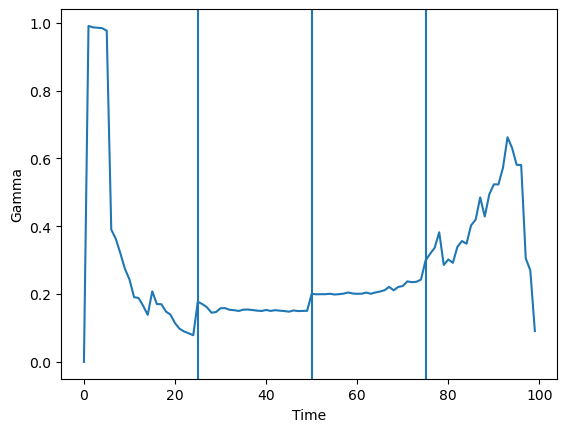

In [ ]:

plt.plot(gamma[-1,:])
plt.axvline(25)
plt.axvline(50)
plt.axvline(75)
plt.xlabel("Time")
plt.ylabel("Gamma")